Import modul and library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_excel("df_combined_banana.xlsx")

In [3]:
df.head(5)

Sl no. District Name                  Market Name Commodity        Variety  \
0    2250      Bhatinda                        Raman    Banana          Other   
1     565        Chamba                       Chamba    Banana          Other   
2    4071        Kollam                      Punalur    Banana     Red Banana   
3    4073         Unnao                        Purwa    Banana  Banana - Ripe   
4     549     Bangalore  Binny Mill (F&V), Bangalore    Banana    Elakki Bale   

    Grade  Min Price (Rs./Quintal)  Max Price (Rs./Quintal)  \
0  Medium                     1700                     2100   
1  Medium                     3300                     3500   
2  Medium                     4600                     5000   
3  Medium                     2150                     2250   
4     FAQ                     1000                     2800   

   Modal Price (Rs./Quintal) Price Date  
0                       2000 2021-03-15  
1                       3400 2021-03-15  
2                       4800 2021-03-15  
3                       2200 2021-03-15  
4                       1900 2021-03-15

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416577 entries, 0 to 416576
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Sl no.                     416577 non-null  int64         
 1   District Name              416577 non-null  object        
 2   Market Name                416577 non-null  object        
 3   Commodity                  416577 non-null  object        
 4   Variety                    416577 non-null  object        
 5   Grade                      416577 non-null  object        
 6   Min Price (Rs./Quintal)    416577 non-null  int64         
 7   Max Price (Rs./Quintal)    416577 non-null  int64         
 8   Modal Price (Rs./Quintal)  416577 non-null  int64         
 9   Price Date                 416577 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 31.8+ MB


dari semua varietas, grade, kelompokkan menjadi satu dan hitung rata-ratanya

In [5]:
grouped_df0 = df.groupby('Price Date')['Modal Price (Rs./Quintal)'].mean()

In [6]:
grouped_df0

Price Date
2021-03-15    2379.447368
2021-03-16    2355.543624
2021-03-17    2344.211268
2021-03-18    2306.200000
2021-03-19    2413.616725
                 ...     
2024-10-27    4277.450704
2024-10-28    3988.364228
2024-10-29    4058.203673
2024-10-30    4141.798230
2024-10-31    4338.655257
Name: Modal Price (Rs./Quintal), Length: 1326, dtype: float64

In [7]:
type(grouped_df0)

pandas.core.series.Series

Download grouped_df untuk digunakan pada saat deployment

In [8]:
#grouped_df.to_excel('grouped_prices_banana.xlsx', sheet_name='Prices')

Tinjau grafik harga dari harga komoditas tersebut untuk melihat trend secara kasat mata

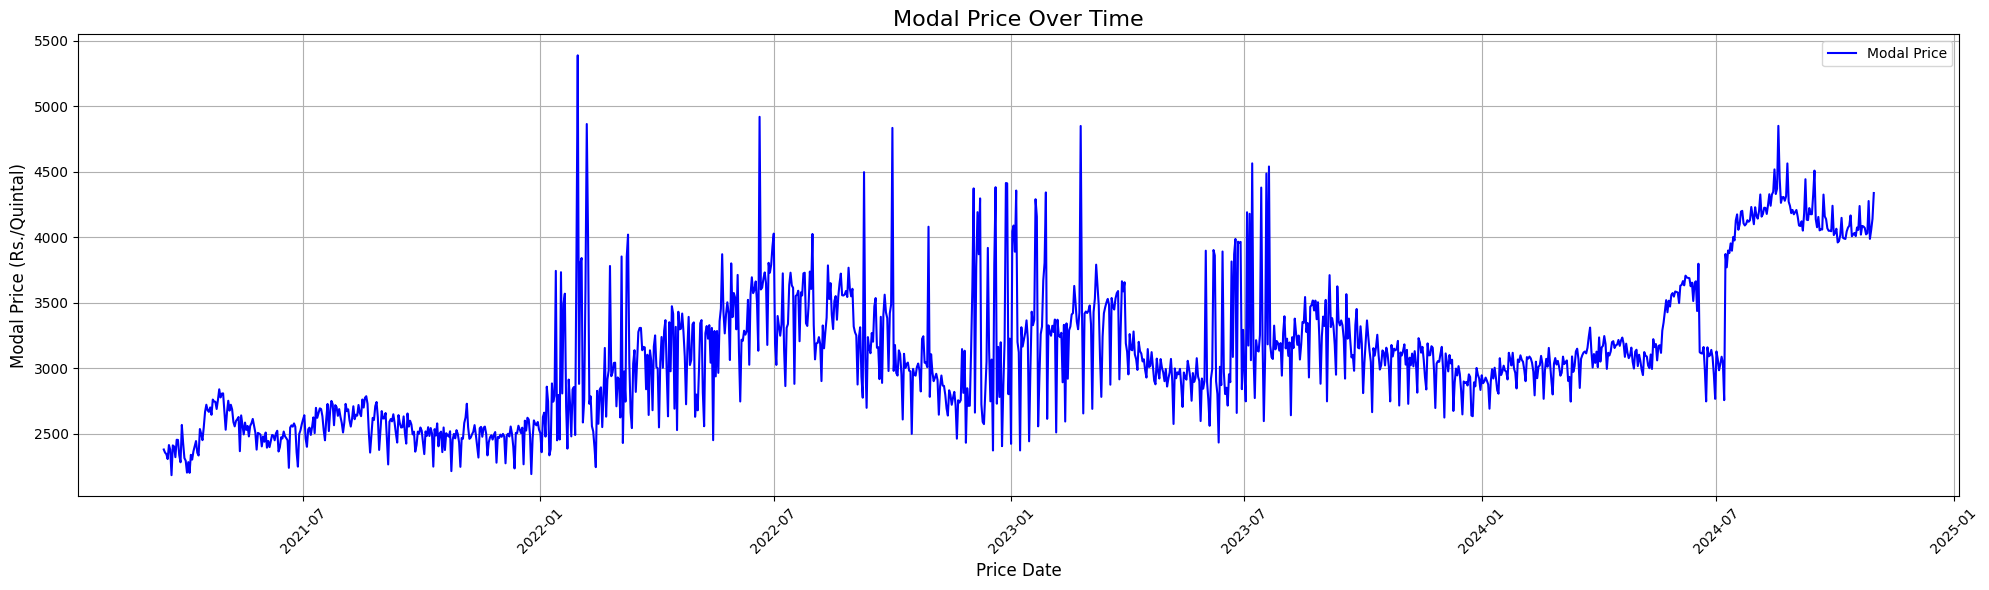

In [9]:
# Plot the Modal Price against the Price Date
plt.figure(figsize=(20, 6))  # You can adjust the figure size
plt.plot(grouped_df0.index, grouped_df0, label='Modal Price', color='blue')

# Add title and labels
plt.title('Modal Price Over Time', fontsize=16)
plt.xlabel('Price Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

ternyata grafik sangat fluktuattif, mari kita coba meninjau hanya beberapa varietas saja

In [10]:
# Group by 'Variety' and count the number of unique 'Price Date' values for each
variety_counts = df.groupby('Variety')['Price Date'].nunique()

# Get the total number of unique 'Price Date' values
total_price_dates = df['Price Date'].nunique()

# Filter for varieties that have records for all 'Price Date'
consistent_varieties = variety_counts[variety_counts == total_price_dates].index

# Display the result
print("Varieties present in all price dates:")
print(consistent_varieties)

Varieties present in all price dates:
Index(['Banana - Ripe', 'Nendra Bale', 'Other', 'Palayamthodan', 'Poovan',
       'Robusta'],
      dtype='object', name='Variety')


In [11]:
# Filter the DataFrame for rows where 'Variety' is 'Robusta' and create a copy
filtered_df = df[df['Variety'] == 'Banana - Ripe'].copy()

# Group by 'Price Date' and calculate the mean for the 'Modal Price (Rs./Quintal)' column
grouped_df_ripe = filtered_df.groupby('Price Date')['Modal Price (Rs./Quintal)'].mean()

# Display the result
(grouped_df_ripe)

Price Date
2021-03-15    2144.310345
2021-03-16    2211.623656
2021-03-17    2181.642105
2021-03-18    2194.827586
2021-03-19    2246.224490
                 ...     
2024-10-27    2902.236842
2024-10-28    3236.611111
2024-10-29    3280.304878
2024-10-30    3237.625000
2024-10-31    3693.676471
Name: Modal Price (Rs./Quintal), Length: 1326, dtype: float64

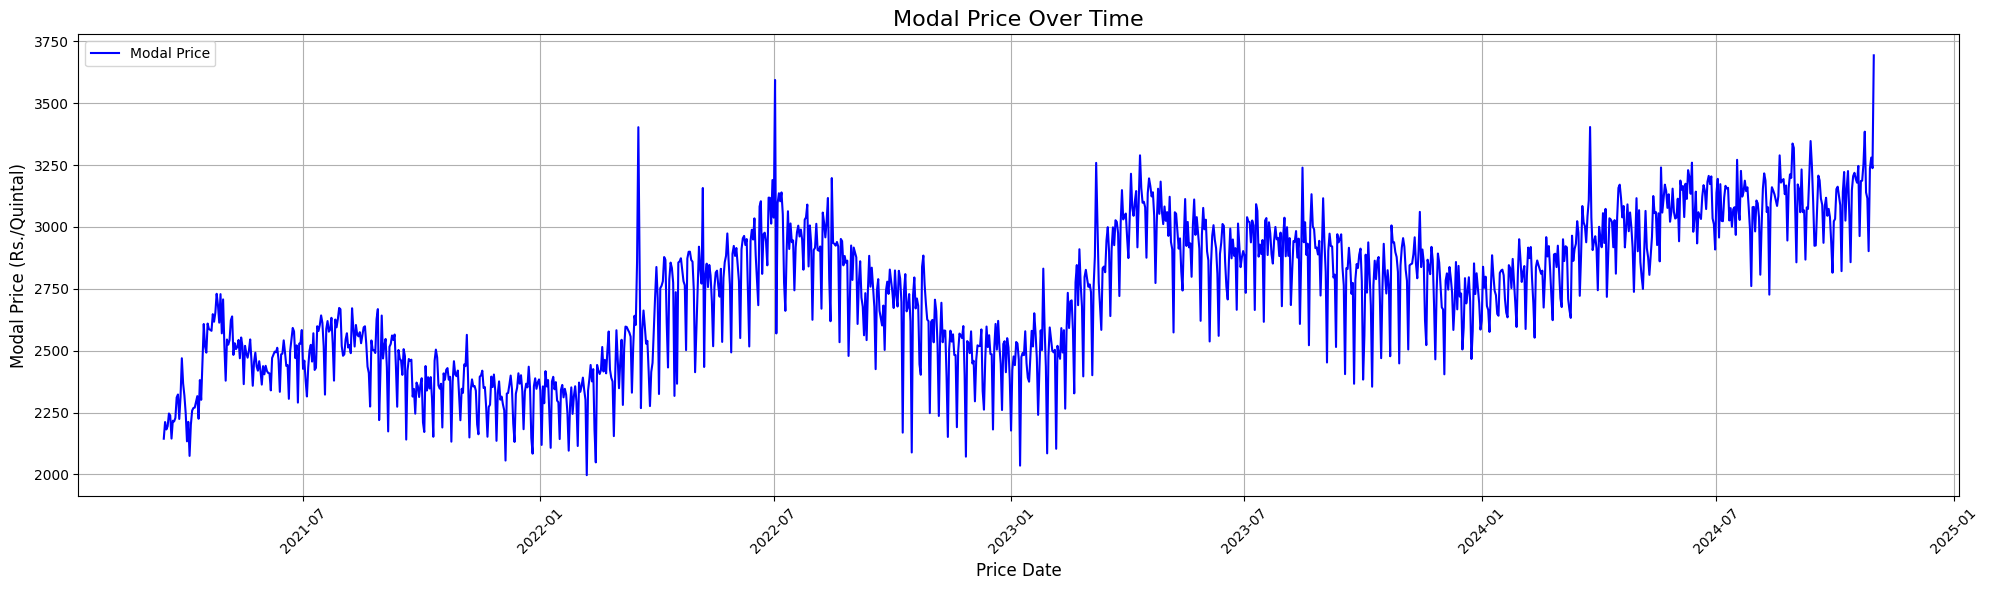

In [12]:
# Plot the Modal Price against the Price Date
plt.figure(figsize=(20, 6))  # You can adjust the figure size
plt.plot(grouped_df_ripe.index, grouped_df_ripe, label='Modal Price', color='blue')

# Add title and labels
plt.title('Modal Price Over Time', fontsize=16)
plt.xlabel('Price Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [13]:
grouped_df=grouped_df_ripe.copy()

In [14]:
# Define the split time
split1 = 2*240
split2 = 4*240

# Get the train set
time_train = grouped_df.index[:split1]
x_train = grouped_df[:split1]

# Get the validation set
time_valid = grouped_df.index[split1:split2]
x_valid = grouped_df[split1:split2]

# Get the test set
time_test = grouped_df.index[split2:]
x_test = grouped_df[split2:]

In [15]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
x_train_scaled = scaler.fit_transform(x_train.values.reshape(-1,1))
x_val_scaled = scaler.transform(x_valid.values.reshape(-1,1))
x_test_scaled = scaler.transform(x_test.values.reshape(-1,1))

# Convert the scaled data back into a DataFrame for easier reading
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=[x_train.name],index=x_train.index)
x_val_scaled_df = pd.DataFrame(x_val_scaled,  columns=[x_valid.name],index=x_valid.index)
x_test_scaled_df = pd.DataFrame(x_test_scaled,  columns=[x_test.name],index=x_test.index)

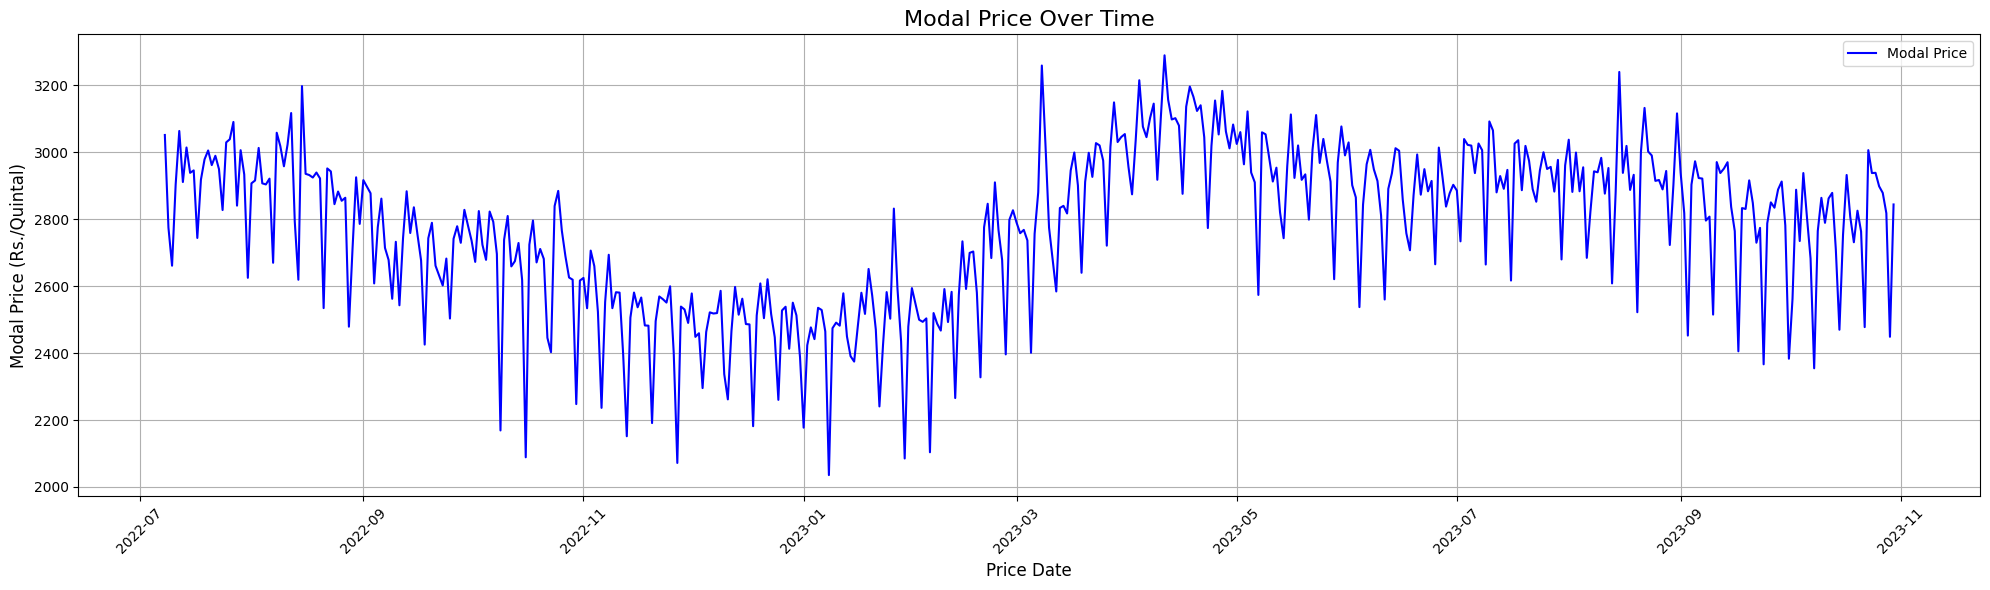

In [16]:
# Plot the Modal Price against the Price Date
plt.figure(figsize=(20, 6))  # You can adjust the figure size
plt.plot(time_valid, x_valid, label='Modal Price', color='blue')

# Add title and labels
plt.title('Modal Price Over Time', fontsize=16)
plt.xlabel('Price Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

#Naive Forecast

In [17]:
series = np.array(grouped_df)

In [18]:
series = scaler.transform(series.reshape(-1,1))

In [19]:
# Generate the naive forecast
split_time = split2
naive_forecast = series[split_time-1 :-1]

# Define time step
time_step = 100

# Print values
print(f'ground truth at time step {time_step}: {x_test_scaled[time_step]}')
print(f'prediction at time step {time_step + 1}: {naive_forecast[time_step +1]}')


ground truth at time step 100: [1.80076407]
prediction at time step 101: [1.80076407]


In [20]:
len(x_test_scaled)

366

In [21]:
len(naive_forecast)

366

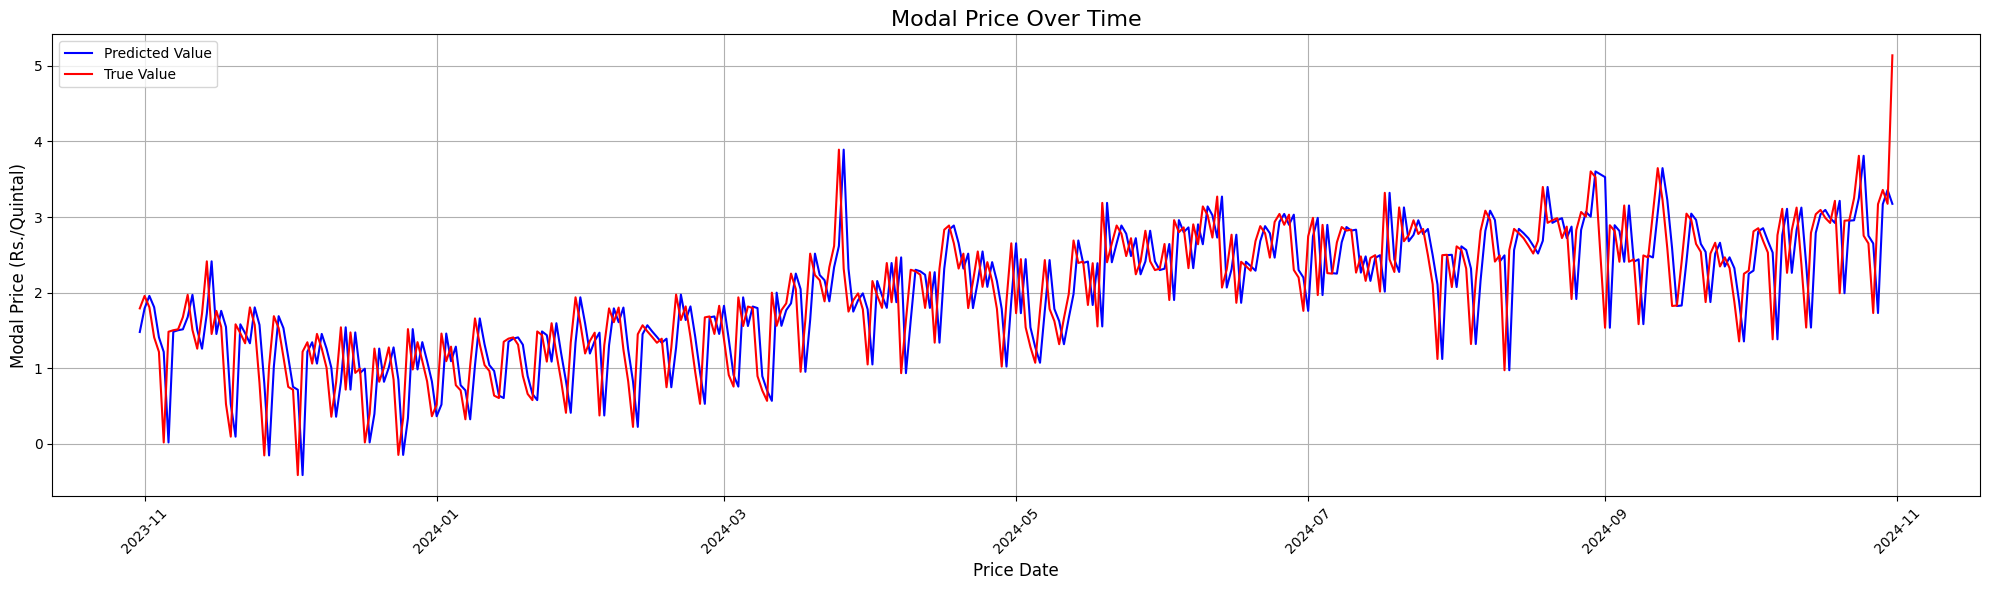

In [22]:
# Reshape results to be 2D (as scaler.inverse_transform expects a 2D array)
#results_reshaped = results.reshape(-1, 1)

# Plot the Modal Price against the Price Date
plt.figure(figsize=(20, 6))  # You can adjust the figure size
plt.plot(x_test_scaled_df.index, naive_forecast, label='Predicted Value', color='blue')

# Plot the predicted values (after reshaping)
plt.plot(x_test_scaled_df.index, x_test_scaled, label='True Value', color='red')

# Add title and labels
plt.title('Modal Price Over Time', fontsize=16)
plt.xlabel('Price Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [23]:
# Instantiate metric objects
mse = tf.keras.metrics.MeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()

# Compute the metrics
print("MSE:", mse(x_test_scaled, naive_forecast).numpy())
print("MAE:", mae(x_test_scaled, naive_forecast).numpy())

naive_mse = mse(x_test_scaled, naive_forecast).numpy()
naive_mae = mae(x_test_scaled, naive_forecast).numpy()

MSE: 0.3764437
MAE: 0.47525305


In [24]:
# Parameters
window_size = 30
batch_size = 32

In [25]:
def windowed_dataset(series, window_size, batch_size):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    #dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size)

    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)

    return dataset

In [26]:
# Generate the dataset windows
x_train_windowed = windowed_dataset(x_train_scaled, window_size, batch_size)
x_val_windowed = windowed_dataset(x_val_scaled, window_size, batch_size)

In [27]:
# Print properties of a single batch
for windows in x_train_windowed.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 30, 1)
shape of second element: (32, 1)


#RNN

In [28]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
])

# Print the model summary
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 30, 40)              │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(x_train_windowed, validation_data=x_val_windowed, epochs=200, callbacks=[lr_schedule])

Epoch 1/200
      9/Unknown 1s 7ms/step - loss: 0.3558

C:\Users\aryad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.4959 - val_loss: 1.3794 - learning_rate: 1.0000e-08
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4958 - val_loss: 1.3793 - learning_rate: 1.1220e-08
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4958 - val_loss: 1.3793 - learning_rate: 1.2589e-08
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4958 - val_loss: 1.3792 - learning_rate: 1.4125e-08
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4957 - val_loss: 1.3792 - learning_rate: 1.5849e-08
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4956 - val_loss: 1.3791 - learning_rate: 1.7783e-08
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4956 - val_loss: 1.3790 - learning_rate: 1.9953e-08
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4955 - val_loss: 1.3789 - learning_rate: 2.2387e-08
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4954 - val_loss: 1.3788 - learning_rat

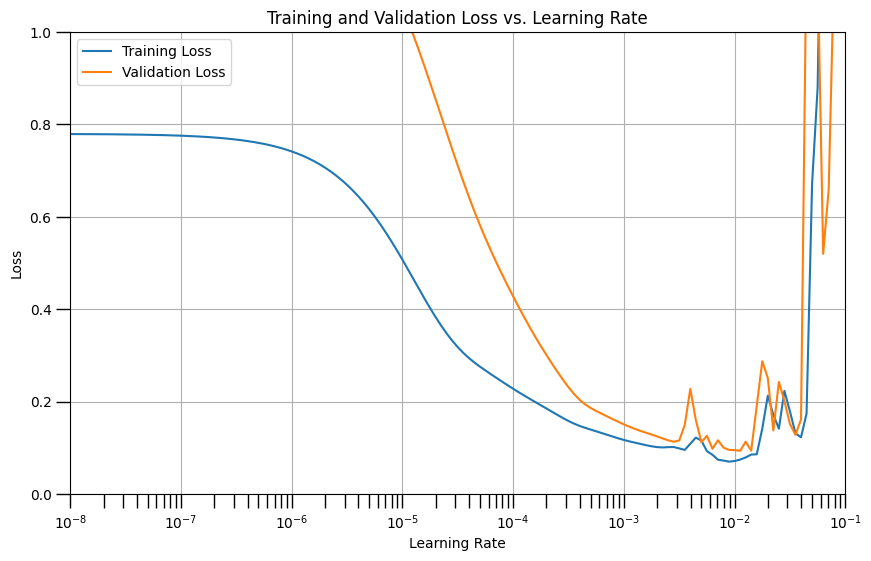

In [30]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(200) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the training loss in log scale
plt.semilogx(lrs, history.history["loss"], label="Training Loss")

# Plot the validation loss in log scale
plt.semilogx(lrs, history.history["val_loss"], label="Validation Loss")

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-1, 0, 1])

# Add a legend
plt.legend()

# Add labels and title
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs. Learning Rate")

# Show the plot
plt.show()

In [31]:
model_RNN=1

In [32]:
# Build the model
model_RNN = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
])

# Set the learning rate
learning_rate = 1e-3

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model_RNN.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

# EarlyStopping callback with patience
early_stopping = EarlyStopping(
    monitor="val_loss",     # Monitor validation loss
    patience=5,             # Wait 5 epochs for improvement
    mode="min",             # Stop when val_loss is minimized
    verbose=1               # Print when training stops early
)

# Train the model with EarlyStopping
history = model_RNN.fit(
    x_train_windowed,
    validation_data=x_val_windowed,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3213 - mae: 0.6834 - val_loss: 0.4258 - val_mae: 0.8195
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3917 - mae: 0.7661 - val_loss: 0.2928 - val_mae: 0.6357
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2461 - mae: 0.5943 - val_loss: 0.2342 - val_mae: 0.5466
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1541 - mae: 0.4436 - val_loss: 0.1858 - val_mae: 0.4691
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1058 - mae: 0.3380 - val_loss: 0.1800 - val_mae: 0.4574
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1044 - mae: 0.3461 - val_loss: 0.1522 - val_mae: 0.4209
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0925 - mae: 0.3185 - val_loss: 0.1435 - val_mae: 0.4076
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0911 - mae: 0.3186 - val_loss: 0.1370 - val_mae: 0.3977
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

In [33]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(grouped_df)-split2-window_size):
  forecast.append(model_RNN.predict(x_test_scaled[time:time + window_size][np.newaxis], verbose=0))

# Slice the points that are aligned with the validation set
#forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_test.shape}')

length of the forecast list: 336
shape of the validation set: (366,)


In [34]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

shape after converting to numpy array: (336, 1, 1)
shape after squeezing: (336,)


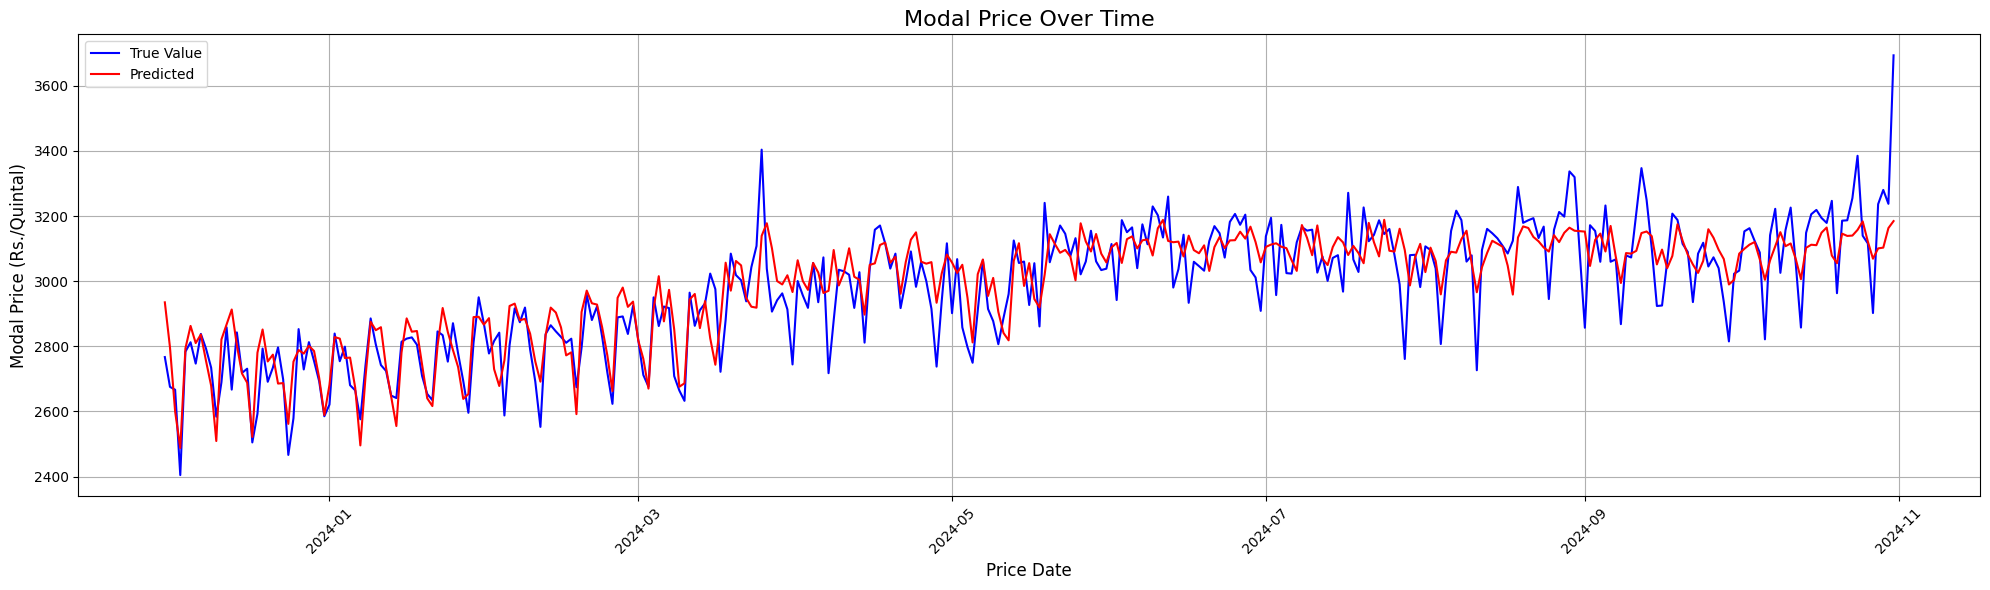

In [35]:
# Reshape results to be 2D (as scaler.inverse_transform expects a 2D array)
results_reshaped = results.reshape(-1, 1)

# Plot the Modal Price against the Price Date
plt.figure(figsize=(20, 6))  # You can adjust the figure size
plt.plot(x_test_scaled_df.index[30:], scaler.inverse_transform(x_test_scaled_df.values[30:].reshape(-1, 1)), label='True Value', color='blue')

# Plot the predicted values (after reshaping)
plt.plot(x_test_scaled_df.index[30:], scaler.inverse_transform(results_reshaped), label='Predicted', color='red')

# Add title and labels
plt.title('Modal Price Over Time', fontsize=16)
plt.xlabel('Price Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [36]:
# Instantiate metric objects
mse = tf.keras.metrics.MeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()

# Compute the metrics
true_values = x_test_scaled_df.values[30:].reshape(-1, 1)
predicted_values = results_reshaped

print("MSE:", mse(true_values, predicted_values).numpy())
print("MAE:", mae(true_values, predicted_values).numpy())

rnn_mse = mse(true_values, predicted_values).numpy()
rnn_mae = mae(true_values, predicted_values).numpy()

MSE: 0.19350927
MAE: 0.33765477


#LSTM

In [37]:
# Build the Model
model_tune1 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
])

# Print the model summary
model_tune1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 30, 64)              │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune1.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune1.fit(x_train_windowed, validation_data=x_val_windowed, epochs=200, callbacks=[lr_schedule])

Epoch 1/200
     15/Unknown 4s 35ms/step - loss: 0.1871

C:\Users\aryad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.1996 - val_loss: 0.8760 - learning_rate: 1.0000e-08
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1991 - val_loss: 0.8760 - learning_rate: 1.1220e-08
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1991 - val_loss: 0.8760 - learning_rate: 1.2589e-08
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1994 - val_loss: 0.8760 - learning_rate: 1.4125e-08
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1990 - val_loss: 0.8760 - learning_rate: 1.5849e-08
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1996 - val_loss: 0.8760 - learning_rate: 1.7783e-08
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1994 - val_loss: 0.8760 - learning_rate: 1.9953e-08
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1993 - val_loss: 0.8760 - learning_rate: 2.2387e-08
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2000 - val_loss: 0.8760 - learning_rat

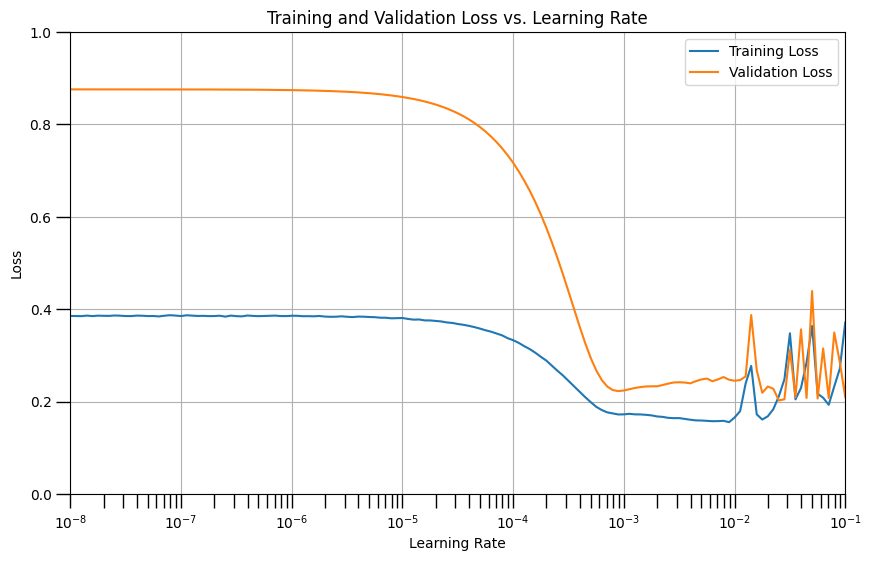

In [39]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(200) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the training loss in log scale
plt.semilogx(lrs, history.history["loss"], label="Training Loss")

# Plot the validation loss in log scale
plt.semilogx(lrs, history.history["val_loss"], label="Validation Loss")

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-1, 0, 1])

# Add a legend
plt.legend()

# Add labels and title
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs. Learning Rate")

# Show the plot
plt.show()

In [40]:
# Reset states generated by Keras
#tf.keras.backend.clear_session()

# Build the model
model_LSTM = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
])

# Set the learning rate
learning_rate = 1e-3

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model_LSTM.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# EarlyStopping callback with patience
early_stopping = EarlyStopping(
    monitor="val_loss",     # Monitor validation loss
    patience=5,             # Wait 5 epochs for improvement
    mode="min",             # Stop when val_loss is minimized
    verbose=1               # Print when training stops early
)

# Train the model with EarlyStopping
history = model_LSTM.fit(
    x_train_windowed,
    validation_data=x_val_windowed,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.1933 - mae: 0.4877 - val_loss: 0.7575 - val_mae: 1.1697
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1745 - mae: 0.4613 - val_loss: 0.5754 - val_mae: 0.9756
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1583 - mae: 0.4351 - val_loss: 0.4040 - val_mae: 0.7799
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1505 - mae: 0.4213 - val_loss: 0.2907 - val_mae: 0.6335
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1512 - mae: 0.4252 - val_loss: 0.2373 - val_mae: 0.5460
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1573 - mae: 0.4399 - val_loss: 0.2235 - val_mae: 0.5120
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1640 - mae: 0.4533 - val_loss: 0.2262 - val_mae: 0.5101
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1674 - mae: 0.4593 - val_loss: 0.2304 - val_mae: 0.5144
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

In [41]:
type(x_test_scaled)

numpy.ndarray

In [42]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(grouped_df)-split2-window_size):
  forecast.append(model_LSTM.predict(x_test_scaled[time:time + window_size][np.newaxis], verbose=0))

# Slice the points that are aligned with the validation set
#forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_test.shape}')

length of the forecast list: 336
shape of the validation set: (366,)


In [43]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

shape after converting to numpy array: (336, 1, 1)
shape after squeezing: (336,)


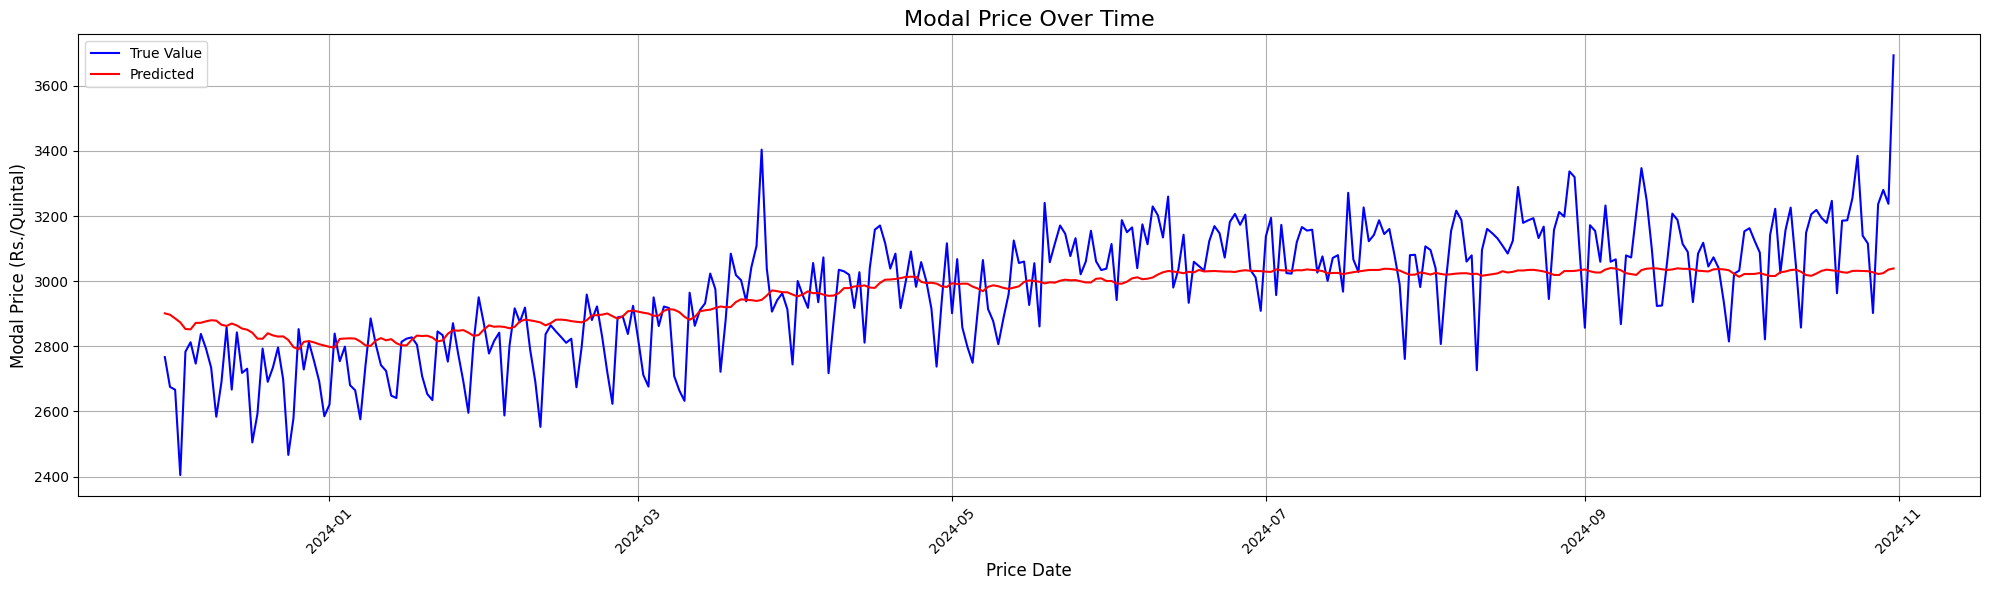

In [44]:
# Reshape results to be 2D (as scaler.inverse_transform expects a 2D array)
results_reshaped = results.reshape(-1, 1)

# Plot the Modal Price against the Price Date
plt.figure(figsize=(20, 6))  # You can adjust the figure size
plt.plot(x_test_scaled_df.index[30:], scaler.inverse_transform(x_test_scaled_df.values[30:].reshape(-1, 1)), label='True Value', color='blue')

# Plot the predicted values (after reshaping)
plt.plot(x_test_scaled_df.index[30:], scaler.inverse_transform(results_reshaped), label='Predicted', color='red')

# Add title and labels
plt.title('Modal Price Over Time', fontsize=16)
plt.xlabel('Price Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [45]:
import plotly.express as px
import pandas as pd

# Prepare a DataFrame for Plotly
plot_df = pd.DataFrame({
    'Price Date': x_test_scaled_df.index[30:],
    'True Value': scaler.inverse_transform(x_test_scaled_df.values[30:].reshape(-1, 1)).flatten(),
    'Predicted': scaler.inverse_transform(results.reshape(-1, 1)).flatten()
})

# Create an interactive plot
fig = px.line(
    plot_df,
    x='Price Date',
    y=['True Value', 'Predicted'],
    labels={'value': 'Modal Price (Rs./Quintal)', 'variable': 'Legend'},
    title='Modal Price Over Time'
)

# Update layout for better aesthetics
fig.update_layout(
    title_font_size=16,
    xaxis_title='Price Date',
    yaxis_title='Modal Price (Rs./Quintal)',
    legend_title='Legend',
    xaxis=dict(tickangle=45),  # Rotate x-axis labels
    template='plotly_white'   # Clean white background
)

# Show the interactive plot
fig.show()


In [46]:
# Instantiate metric objects
mse = tf.keras.metrics.MeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()

# Compute the metrics
true_values = x_test_scaled_df.values[30:].reshape(-1, 1)
predicted_values = results_reshaped

print("MSE:", mse(true_values, predicted_values).numpy())
print("MAE:", mae(true_values, predicted_values).numpy())

lstm_mse = mse(true_values, predicted_values).numpy()
lstm_mae = mae(true_values, predicted_values).numpy()

MSE: 0.37001714
MAE: 0.47855288


In [47]:
model_name = ['rnn', 'lstm']
lst_mse = [rnn_mse, lstm_mse]
lst_mae = [rnn_mae, lstm_mae]

for i in range(len(model_name)):
    print(f'MSE dari {model_name[i]} adalah {lst_mse[i]}')
    print(f'MAE dari {model_name[i]} adalah {lst_mae[i]}')

smallest_mse = np.argmin(lst_mse)
smallest_mae = np.argmin(lst_mae)

print(f'Model terbaik adalah {model_name[smallest_mse]} berdasarkan MSE terkecil')
print(f'Model terbaik adalah {model_name[smallest_mae]} berdasarkan MAE terkecil')

MSE dari rnn adalah 0.1935092657804489
MAE dari rnn adalah 0.3376547694206238
MSE dari lstm adalah 0.3700171411037445
MAE dari lstm adalah 0.4785528779029846
Model terbaik adalah rnn berdasarkan MSE terkecil
Model terbaik adalah rnn berdasarkan MAE terkecil


Forecast

In [48]:
numpy_grouped_df=grouped_df.to_numpy()

In [49]:
numpy_grouped_df_scaled = scaler.transform(numpy_grouped_df.reshape(-1,1))

In [50]:
days = 240

In [51]:
len(numpy_grouped_df)/240

5.525

Plot ulang RNN

In [52]:
# Initialize lists for forecast
days = 240
forecast = []
result_forecast = numpy_grouped_df_scaled[-240:].tolist()  # Use the last 30 values as the starting point

# Flatten result_forecast if it contains nested lists
# Assuming numpy_grouped_df_scaled[-30:] is a 2D array or list of lists
result_forecast = [item[0] if isinstance(item, list) else float(item) for item in result_forecast]

# Forecast for 365 days
for _ in range(days):
    # Prepare input for the model
    input_data = np.array(result_forecast[-240:]).reshape(1, 240, 1)  # Reshape correctly
    
    # Predict and extract the scalar value
    prediksi = model_RNN.predict(input_data)[0][0]  # Extract scalar from prediction array
    
    # Append the prediction
    forecast.append(prediksi)  # For final forecast output
    result_forecast.append(prediksi)  # For generating subsequent predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

In [53]:
last_30_df = pd.DataFrame(numpy_grouped_df[-240:], columns=[grouped_df.name],index=grouped_df[-240:].index)

In [54]:
# Assume forecast contains the 30 predicted values
import pandas as pd

# Create a new datetime index for the next 30 days
new_dates = pd.date_range(start=last_30_df.index[-1] + pd.Timedelta(days=1), periods=days)

# Create a new DataFrame with the forecasted values
forecast_df = pd.DataFrame({'Modal Price (Rs./Quintal)': (scaler.inverse_transform(np.array(forecast).reshape(-1,1)).flatten())}, index=new_dates)

# Concatenate the existing DataFrame with the forecasted DataFrame
extended_df = pd.concat([last_30_df, forecast_df])

# Display the extended DataFrame
print(len(extended_df))

480


In [55]:
import plotly.graph_objects as go
import pandas as pd

# Concatenate the actual and forecast DataFrames into a single DataFrame
combined_df = pd.concat([last_30_df, forecast_df])

# Create a figure
fig = go.Figure()


# Add a trace for the combined actual and forecast data (continuous line)
fig.add_trace(go.Scatter(
    x=extended_df.index,  # Use the combined index of both actual and forecast
    y=extended_df['Modal Price (Rs./Quintal)'],
    mode='lines',  # Line plot
    name='Predicted Price',  # Label for combined data
    line=dict(color='red')  # Blue color for the forecasted data
))

# Add a trace for the last 30 actual values
fig.add_trace(go.Scatter(
    x=last_30_df.index,  # Only the index for the last 30 actual values
    y=last_30_df['Modal Price (Rs./Quintal)'],
    mode='lines',  # Line plot
    name='True Price',  # Label for the last 30 actual data
    line=dict(color='blue')  # Green color for actual data
))


# Update layout for better aesthetics
fig.update_layout(
    title='Modal Price Over Time',
    title_font_size=16,
    xaxis_title='Price Date',
    yaxis_title='Modal Price (Rs./Quintal)',
    legend_title='Legend',
    xaxis=dict(tickangle=45),  # Rotate x-axis labels
    template='plotly_white'   # Clean white background
)

# Show the interactive plot
fig.show()


Plot ulang LSTM

In [56]:
# Initialize lists for forecast
days = 1*240
forecast = []
result_forecast = numpy_grouped_df_scaled[-1*240:].tolist()  # Use the last 30 values as the starting point

# Flatten result_forecast if it contains nested lists
# Assuming numpy_grouped_df_scaled[-30:] is a 2D array or list of lists
result_forecast = [item[0] if isinstance(item, list) else float(item) for item in result_forecast]

# Forecast for 365 days
for _ in range(days):
    # Prepare input for the model
    input_data = np.array(result_forecast[-1*240:]).reshape(1, 1*240, 1)  # Reshape correctly
    
    # Predict and extract the scalar value
    prediksi = model_LSTM.predict(input_data)[0][0]  # Extract scalar from prediction array
    
    # Append the prediction
    forecast.append(prediksi)  # For final forecast output
    result_forecast.append(prediksi)  # For generating subsequent predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━

In [57]:
last_30_df = pd.DataFrame(numpy_grouped_df[-240:], columns=[grouped_df.name],index=grouped_df[-240:].index)

In [58]:
# Assume forecast contains the 30 predicted values
import pandas as pd

# Create a new datetime index for the next 30 days
new_dates = pd.date_range(start=last_30_df.index[-1] + pd.Timedelta(days=1), periods=days)

# Create a new DataFrame with the forecasted values
forecast_df = pd.DataFrame({'Modal Price (Rs./Quintal)': (scaler.inverse_transform(np.array(forecast).reshape(-1,1)).flatten())}, index=new_dates)

# Concatenate the existing DataFrame with the forecasted DataFrame
extended_df = pd.concat([last_30_df, forecast_df])

# Display the extended DataFrame
print(len(extended_df))

480


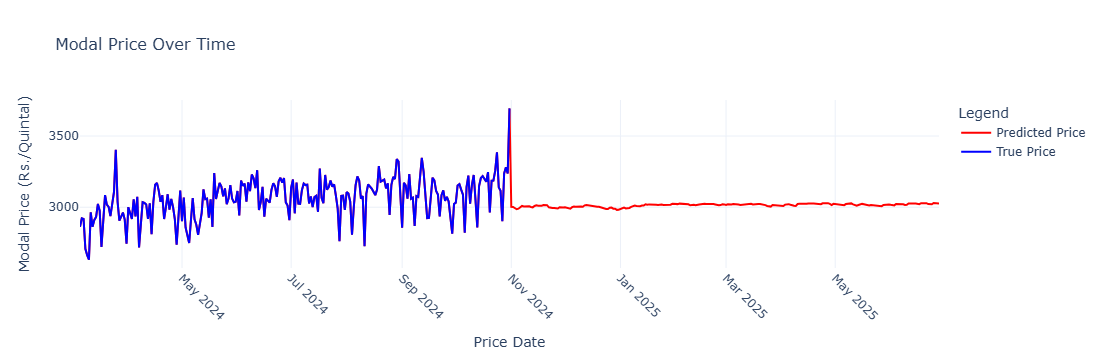

In [59]:
import plotly.graph_objects as go
import pandas as pd

# Concatenate the actual and forecast DataFrames into a single DataFrame
combined_df = pd.concat([last_30_df, forecast_df])

# Create a figure
fig = go.Figure()


# Add a trace for the combined actual and forecast data (continuous line)
fig.add_trace(go.Scatter(
    x=extended_df.index,  # Use the combined index of both actual and forecast
    y=extended_df['Modal Price (Rs./Quintal)'],
    mode='lines',  # Line plot
    name='Predicted Price',  # Label for combined data
    line=dict(color='red')  # Blue color for the forecasted data
))

# Add a trace for the last 30 actual values
fig.add_trace(go.Scatter(
    x=last_30_df.index,  # Only the index for the last 30 actual values
    y=last_30_df['Modal Price (Rs./Quintal)'],
    mode='lines',  # Line plot
    name='True Price',  # Label for the last 30 actual data
    line=dict(color='blue')  # Green color for actual data
))


# Update layout for better aesthetics
fig.update_layout(
    title='Modal Price Over Time',
    title_font_size=16,
    xaxis_title='Price Date',
    yaxis_title='Modal Price (Rs./Quintal)',
    legend_title='Legend',
    xaxis=dict(tickangle=45),  # Rotate x-axis labels
    template='plotly_white'   # Clean white background
)

# Show the interactive plot
fig.show()


Save model

In [60]:
import joblib

# Assuming `scaler` is your StandardScaler object
joblib.dump(scaler, 'scaler_banana.pkl')

#save model
model_RNN.save('best_banana_model.h5')